In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import pprint

np.random.seed(42)

In [2]:
def read_float_with_comma(num):
    return float(num.replace(",", "."))

Daten laden

In [3]:
df = pd.read_csv('Exercise 1 - Transaction Classification - Data Set.csv', sep=';')

In [4]:
df.head(n=10)

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure
5,5,89990201.0,15.07.2016,15.07.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance
6,6,89990201.0,08.07.2016,08.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-05-09...,Kartenzahlung,9736000780,25190001,-19.99,EUR,standardOfLiving
7,7,89990201.0,05.07.2016,05.07.2016,Drogerie,Dm Fil.1137 H:65128//Nuernberg/De 2 016-04-19T...,Dm Drogeriemarkt Sagt Danke,7755566780,25190001,-28.85,EUR,standardOfLiving
8,8,89990201.0,04.07.2016,04.07.2016,Geldanlage,Ccbade31Xxx De71310108339900123456 Sparen End-...,Michael Koffer,DE69790800529736000780,DRESDEFF790,-300.00,EUR,finance
9,9,89990201.0,01.07.2016,01.07.2016,Bargeld,"16.02/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-50.00,EUR,private


In [5]:
df.dtypes

Unnamed: 0                             int64
Auftragskonto                        float64
Buchungstag                           object
Valutadatum                           object
Buchungstext                          object
Verwendungszweck                      object
Beguenstigter/Zahlungspflichtiger     object
Kontonummer                           object
BLZ                                   object
Betrag                                object
Waehrung                              object
label                                 object
dtype: object

In [6]:
# 70/30 split

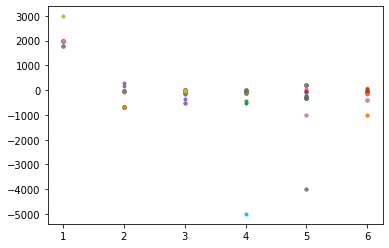

In [7]:
df['label']
labels={'income':1,'living':2,'leisure':3,'standardOfLiving':4,'finance':5,'private':6}

betrag = []
for ind, val in enumerate(df['Betrag']):
    plt.plot(labels[df['label'][ind]],read_float_with_comma(val),'.')
#plt.axis([0,7,-250,250])
plt.show()

In [8]:

zweck_all = []
labels = []
for text, empf, verw, label in zip(df['Buchungstext'],df['Beguenstigter/Zahlungspflichtiger'], df['Verwendungszweck'],df['label']):
    zweck_all.append(str(text) + ' ' + str(empf) + ' ' + str(verw))
    #zweck_all.append(str(text) + ' ' + str(verw))
    #zweck_all.append(str(text) + ' ' + str(empf))
    #zweck_all.append(str(text))
    labels.append(str(label))
print(zweck_all)
print(np.shape(zweck_all))
print(np.shape(labels))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(zweck_all, labels, random_state=42)
    
zweck = X_train
    
count = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b')    
bag = count.fit_transform(X_train)
bag_test = count.transform(X_test)

print(bag.toarray())
print(bag_test.toarray())
#count.get_feature_names()


['Lohn / Gehalt Adorsys GmbH & Co. KG Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: Notprovided Kundenreferenz: Nsct1603300013660000000000000000001 Gutschrift', 'Miete Georg Tasche Byladem1Sbt De12773501123456789889 Miete Beuthener Str. 25 End-To-End-Ref.: Notprovided Dauerauftrag Dauerauftrag', 'Bargeld Bargeld 21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur 0,00 Einzahlung/Auszahlung Ga Nr55508568 Blz76010085 9', 'Lebensmittel / Getraenke Kartenzahlung 2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20T17:54:45 Kfn 9 Vj 1612 Lastschrift', 'Spontanausgabe neue Playstation Amazon', 'Mieteinnahmen Isabel Anna Mietzuschuss End-To-End-Ref.: Notprovided Kundenreferenz: Nsct1603080001510000000000000000006 Gutschrift', 'Lebensmittel / Getraenke Kartenzahlung 2831 Edeka Neubauer Nuernb.//Nuernb 2016-05-09T17:54:45 Kfn 9 Vj 1612 Lastschrift', 'Drogerie Dm Drogeriemarkt Sagt Danke Dm Fil.1137 H:65128//Nuernberg/De 2 016-04-19T17:03:43Folgenr.001 Verf Alld.2020 -12', 'Geldanlage Michael Koffer Ccbade

In [9]:
vectorizer = TfidfVectorizer(min_df=1,token_pattern='(?u)\\b[\\w-]+\\b')
X = vectorizer.fit_transform(zweck)
idf = vectorizer.idf_

pp = pprint.PrettyPrinter(indent=4)
stats = dict(zip(vectorizer.get_feature_names(), idf))
pp.pprint(stats)
import operator
max(stats.items(), key=operator.itemgetter(1))[0]
min(stats.items(), key=operator.itemgetter(1))[0]

{   '0': 2.8781919750003624,
    '00': 2.5008977438588946,
    '000': 5.363098624788363,
    '0000000000': 2.798149267326826,
    '001': 2.6550484236861527,
    '00eur0': 3.348195604246098,
    '01': 3.283657083108527,
    '016-02-03t16': 5.363098624788363,
    '016-02-16t17': 4.446807892914208,
    '016-02-18t21': 5.363098624788363,
    '016-02-27t11': 5.363098624788363,
    '016-03-05t09': 5.363098624788363,
    '016-03-19t17': 5.363098624788363,
    '016-04-19t17': 4.669951444228417,
    '016-06-01t17': 5.363098624788363,
    '0164378887929309': 5.363098624788363,
    '01e': 5.363098624788363,
    '02': 3.165874047452143,
    '02-05t23': 5.363098624788363,
    '02-20t17': 5.363098624788363,
    '03': 3.1118068261818674,
    '03-19t15': 5.363098624788363,
    '03t12': 5.363098624788363,
    '04': 3.571339155560308,
    '04032016': 5.363098624788363,
    '05': 5.363098624788363,
    '06': 4.669951444228417,
    '07': 5.363098624788363,
    '07folgenr': 5.363098624788363,
    '08': 4.9

'lastschrift'

In [10]:
feature_names = vectorizer.get_feature_names()

doc = 0
feature_index = X[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [X[doc, x] for x in feature_index])

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

dauerauftrag 0.40195740873013946
notprovided 0.17320928712309627
end-to-end-ref 0.16593801160294122
25 0.2529677557987348
str 0.27334506668458336
beuthener 0.27334506668458336
de12773501123456789889 0.27334506668458336
byladem1sbt 0.27334506668458336
tasche 0.27334506668458336
georg 0.27334506668458336
miete 0.5182620209583937


In [11]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(bag.toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0]
 [1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [12]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(bag.toarray(), Y_train)
predicted = clf.predict(bag_test.toarray())

result = list(zip(predicted,Y_test))
i = 0
for val in result:
    if val[0] == val[1]:
        i+=1

print(result)
print('accuracy: ', i/len(Y_test))

from sklearn.metrics import confusion_matrix
#class_names = ['leisure', 'standardOfLiving', 'private', 'finance', 'income', 'living']
class_names = ['finance', 'income', 'leisure', 'living', 'private', 'standardOfLiving']

confusion_matrix(Y_test, predicted, labels=class_names)


[('standardOfLiving', 'standardOfLiving'), ('living', 'living'), ('standardOfLiving', 'living'), ('finance', 'finance'), ('finance', 'finance'), ('leisure', 'leisure'), ('finance', 'finance'), ('income', 'income'), ('private', 'private'), ('living', 'living'), ('leisure', 'leisure'), ('standardOfLiving', 'standardOfLiving'), ('income', 'income'), ('leisure', 'leisure'), ('standardOfLiving', 'standardOfLiving'), ('leisure', 'standardOfLiving'), ('leisure', 'leisure'), ('standardOfLiving', 'standardOfLiving'), ('standardOfLiving', 'standardOfLiving'), ('leisure', 'leisure'), ('standardOfLiving', 'standardOfLiving'), ('leisure', 'leisure'), ('income', 'income'), ('leisure', 'leisure'), ('income', 'income'), ('standardOfLiving', 'living'), ('standardOfLiving', 'standardOfLiving'), ('leisure', 'leisure'), ('standardOfLiving', 'standardOfLiving'), ('finance', 'finance'), ('private', 'private'), ('private', 'private'), ('living', 'living'), ('leisure', 'private'), ('leisure', 'leisure'), ('le

array([[ 8,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0],
       [ 0,  0, 16,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  2],
       [ 1,  0,  1,  0,  4,  0],
       [ 0,  0,  1,  0,  0, 11]])

Confusion matrix, without normalization
[[ 8  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0  5  0  2]
 [ 1  0  1  0  4  0]
 [ 0  0  1  0  0 11]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.71 0.   0.29]
 [0.17 0.   0.17 0.   0.67 0.  ]
 [0.   0.   0.08 0.   0.   0.92]]


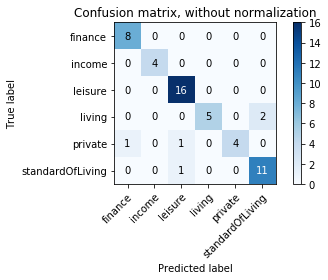

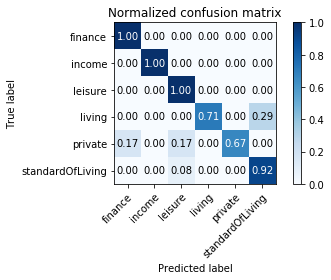

                  precision    recall  f1-score   support

         finance       0.89      1.00      0.94         8
          income       1.00      1.00      1.00         4
         leisure       0.89      1.00      0.94        16
          living       1.00      0.71      0.83         7
         private       1.00      0.67      0.80         6
standardOfLiving       0.85      0.92      0.88        12

        accuracy                           0.91        53
       macro avg       0.94      0.88      0.90        53
    weighted avg       0.91      0.91      0.90        53



In [13]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predicted, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

from sklearn.metrics import classification_report
print(classification_report(Y_test, predicted, target_names=class_names))

In [14]:
#area under the curve

In [15]:
from sklearn.datasets import fetch_20newsgroups
 # newsgroups categories
categories = ['alt.atheism','talk.religion.misc',
              'comp.graphics','sci.space']

posts = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))




In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(posts.data)

In [19]:
from sklearn.feature_selection import chi2
# compute chi2 for each feature
print(np.shape(posts.data))
print(np.shape(posts.target))
print(count.get_feature_names())
chi2score = chi2(bag,Y_train)[0]


(2034,)
(2034,)
['0', '00', '000', '0000000000', '001', '00eur0', '01', '016-02-03t16', '016-02-16t17', '016-02-18t21', '016-02-27t11', '016-03-05t09', '016-03-19t17', '016-04-19t17', '016-06-01t17', '0164378887929309', '01e', '02', '02-05t23', '02-20t17', '03', '03-19t15', '03t12', '04', '04032016', '05', '06', '07', '07folgenr', '08', '1', '10', '100', '10103084736793zalando', '10316011', '10355311', '10355499', '10355735', '10355942', '10355969', '10355999', '11', '1137', '116', '12', '12272140', '122721405', '13', '14', '140', '14t12', '15', '150244534', '150257651', '16', '16-01-02t14', '16-02-20t15', '16-02-26t15', '16-31', '161080109883418', '1612', '162146', '1637782719640441', '17', '18', '19', '1u1', '2', '20', '20-12', '201', '2016', '2016-01-23t13', '2016-02-01t06', '2016-02-13t', '2016-02-27t10', '2016-03', '2016-03-09t07', '2016-03-12', '2016-03-15t17', '2016-05-04t17', '2016-05-09t17', '2016-05-10t17', '2016-06-02t17', '2016-07-20t17', '2016-12', '2020', '2020-12', '2099

In [24]:
from pylab import barh,plot,yticks,show,grid,xlabel,figure
%matplotlib
figure(figsize=(6,6))
wscores = zip(count.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = list(zip(*wchi2[-50:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()

Using matplotlib backend: Qt5Agg
